# Assignment 2: Neural Networks
---
Samarth Kumar

README:
1. Required dependencies:


*   NumPy
*   Pandas
*   Matplotlib
*   Random

2. Upload the following files along with the notebook:


*   X_test.csv
*   X_train.csv
*   Y_test.csv
*   Y_train.csv

3. Run the code blocks in chronological order and everything is good to go.





# QUESTION 1

Binary Classification would use a Sigmoid activation function at the output layer and produce probability values in range (0, 1). Regression using MSE loss would use a linear activation in the output layer. Log loss (binary classification) wants the model to confidently have correct predictions and produce a linear gradient for stable weight updates. MSE loss (regression) produces a quadratic gradient and is sensitive to outliers because it penalizes squared errors.

# QUESTION 2

## 1. What is the activation function you will choose for the output layer?

For this assignment, I am tasked with implementing a neural network for regression. Because regression involves continuous output values, a **linear activation** at the output layer is the best choice. We want unbounded output values and to preserve the relationships (output can vary freely based on the learned weights).

For the hidden layer, however, I primarily used Sigmoid activation and later experimented with ReLU and Tanh.

For the output layer, I used **linear activation** for all experiments.

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
X_train = pd.read_csv("X_train.csv", header=None, delimiter=r"\s+").astype(float).values
Y_train = pd.read_csv("Y_train.csv", header=None, delimiter=r"\s+").astype(float).values
X_test = pd.read_csv("X_test.csv", header=None, delimiter=r"\s+").astype(float).values
Y_test = pd.read_csv("Y_test.csv", header=None, delimiter=r"\s+").astype(float).values

In [ ]:
random.seed(25)

## 2. How many neurons should be in the output layer? Why?
There should only be **one** neuron in the output layer. From examining the data, Y_train and Y_test both represent 1D arrays, and the given task is regression. Since a regression task involves predicting a single continuous value, only one neuron is necessary in the output layer.

For questions 3-6, I am using a sigmoid activation function for consistency, only changing learning_rate during question 5 and changing number of neurons in hidden layer for question 6.

#### Activation Functions

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

activation_functions = {
    "sigmoid": (sigmoid, sigmoid_derivative),
    "relu": (relu, relu_derivative),
    "tanh": (tanh, tanh_derivative)
}

Initialize and Update parameters

In [ ]:
def initialize_params(X_train, hidden_size):
  W1 = np.random.randn(X_train.shape[1], hidden_size) * 0.01
  b1 = np.zeros((1, hidden_size))
  W2 = np.random.randn(hidden_size, 1) * 0.01
  b2 = np.zeros((1, 1))

  return W1, b1, W2, b2

def update_params(W1, b1, W2, b2, dL_dW1, dL_db1, dL_dW2, dL_db2):
  W1 -= learning_rate * dL_dW1
  b1 -= learning_rate * dL_db1
  W2 -= learning_rate * dL_dW2
  b2 -= learning_rate * dL_db2

  return W1, b1, W2, b2

Calculate Loss

In [ ]:
# MSE Loss
def mse_loss(Y, Y_pred):
    return np.mean((Y - Y_pred) ** 2)

Forward Pass

In [ ]:
def forward_pass(X, W1, b1, W2, b2, activation_func):
    Z1 = np.dot(X, W1) + b1
    A1 = activation_func(Z1)
    Z2 = np.dot(A1, W2) + b2
    return Z1, A1, Z2

Backpropagation

In [ ]:
def backpropagation(X, Y, Z1, A1, Z2, W2, activation_deriv, learning_rate):
    dL_dY_pred = 2 * (Z2 - Y) / Y.shape[0]
    dL_dW2 = np.dot(A1.T, dL_dY_pred)
    dL_db2 = np.sum(dL_dY_pred, axis=0, keepdims=True)
    dL_dA1 = np.dot(dL_dY_pred, W2.T)
    dL_dZ1 = dL_dA1 * activation_deriv(A1)
    dL_dW1 = np.dot(X.T, dL_dZ1)
    dL_db1 = np.sum(dL_dZ1, axis=0, keepdims=True)

    # Gradient clipping for higher learning rates to prevent instability.
    if learning_rate > 0.1:
        dL_dW1 = np.clip(dL_dW1, -3, 3)
        dL_db1 = np.clip(dL_db1, -3, 3)
        dL_dW2 = np.clip(dL_dW2, -3, 3)
        dL_db2 = np.clip(dL_db2, -3, 3)

    return dL_dW1, dL_db1, dL_dW2, dL_db2

Training the neural network

In [ ]:
def train(X_train, Y_train, X_test, Y_test, hidden_size, learning_rate, num_epochs, activation):

    activation_func, activation_deriv = activation_functions[activation]
    print(f"Training with {hidden_size} hidden neurons using {activation} activation")

    # Initialize parameters.
    W1, b1, W2, b2 = initialize_params(X_train, hidden_size)


    losses = []
    for epoch in range(num_epochs):
        Z1, A1, Z2 = forward_pass(X_train, W1, b1, W2, b2, activation_func)

        # Calculate the loss.
        mse = mse_loss(Y_train, Z2)
        losses.append(mse)
        best_val_loss = float('inf')

        # Backpropagation.
        dL_dW1, dL_db1, dL_dW2, dL_db2 = backpropagation(
            X_train, Y_train, Z1, A1, Z2, W2,
            activation_deriv, learning_rate
        )

        # Update the parameters.
        W1, b1, W2, b2 = update_params(
            W1, b1, W2, b2,
            dL_dW1, dL_db1, dL_dW2, dL_db2
        )

        # Print the loss every 100 epochs.
        if epoch % 100 == 0 or epoch == num_epochs-1:
            print(f"    Epoch {epoch}, Train Loss: {mse:.4f}")

    # Generate Predictions
    _, _, Y_pred = forward_pass(X_test, W1, b1, W2, b2, activation_func)

    # Return the parameters and predictions for further analysis.
    return {
        "hidden_size": hidden_size,
        "activation_function": activation,
        "final_loss": mse,
        "losses": losses,
        "weights": (W1, b1, W2, b2),
        "predictions": Y_pred
    }

Testing the neural network with manually set parameters:


*   Sigmoid Activation at hidden layer
*   10 neurons in the hidden layer
*   Learning rate of 0.001
*   1000 epochs



In [ ]:
# Define training parameters
hidden_size = 10  # Choose the number of hidden neurons
learning_rate = 0.001
num_epochs = 1000
activation = "relu"  # Choose from "sigmoid", "relu", "tanh"

# Train the model
results = train(X_train, Y_train, X_test, Y_test, hidden_size, learning_rate, num_epochs, activation)

Training with 10 hidden neurons using relu activation
    Epoch 0, Train Loss: 5716.8173
    Epoch 100, Train Loss: 130.5496
    Epoch 200, Train Loss: 82.7155
    Epoch 300, Train Loss: 54.7537
    Epoch 400, Train Loss: 22.6189
    Epoch 500, Train Loss: 3.2968
    Epoch 600, Train Loss: 0.4029
    Epoch 700, Train Loss: 0.0475
    Epoch 800, Train Loss: 0.0055
    Epoch 900, Train Loss: 0.0007
    Epoch 999, Train Loss: 0.0001


## 3) Average MSE Loss

In [ ]:
average_loss = np.mean(results["losses"])
print(f"Average Loss: {average_loss}")

Average Loss: 429.3650162432568


---

## 4) Plot the training loss over the number of iterations

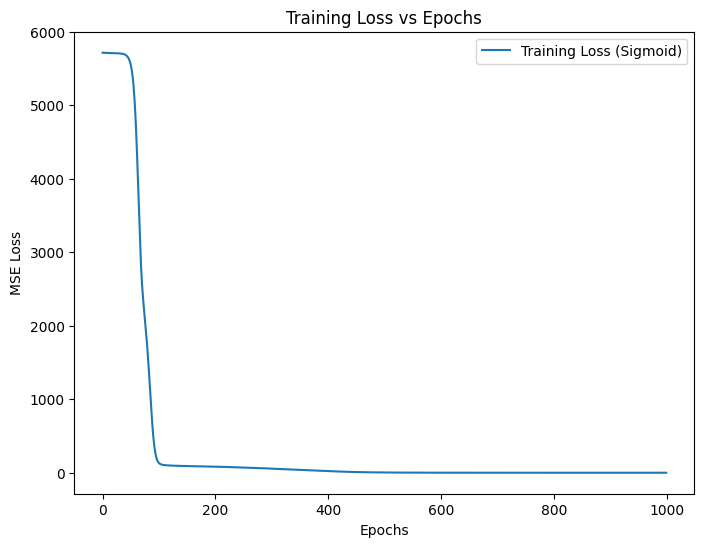

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(results["losses"], label="Training Loss (Sigmoid)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title(f"Training Loss vs Epochs")
plt.legend()
plt.show()

---

## 5) Testing different learning rates

learning_rate = 0.001

In [ ]:
lr1 = train(X_train, Y_train, X_test, Y_test, 10, 0.001, 1500, 'sigmoid')

Training with 10 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.1436
    Epoch 100, Train Loss: 4639.4233
    Epoch 200, Train Loss: 3250.8200
    Epoch 300, Train Loss: 2614.2508
    Epoch 400, Train Loss: 2228.3140
    Epoch 500, Train Loss: 1958.8492
    Epoch 600, Train Loss: 1755.1036
    Epoch 700, Train Loss: 1592.2426
    Epoch 800, Train Loss: 1456.4613
    Epoch 900, Train Loss: 1339.6337
    Epoch 1000, Train Loss: 1236.5445
    Epoch 1100, Train Loss: 1142.3412
    Epoch 1200, Train Loss: 1052.5444
    Epoch 1300, Train Loss: 967.8513
    Epoch 1400, Train Loss: 890.7281
    Epoch 1499, Train Loss: 822.3651


learning_rate = 0.01

In [ ]:
lr2 = train(X_train, Y_train, X_test, Y_test, 10, 0.01, 1500, 'sigmoid')

Training with 10 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.5102
    Epoch 100, Train Loss: 4639.7141
    Epoch 200, Train Loss: 3250.9442
    Epoch 300, Train Loss: 2614.3388
    Epoch 400, Train Loss: 2228.3825
    Epoch 500, Train Loss: 1958.9049
    Epoch 600, Train Loss: 1755.1505
    Epoch 700, Train Loss: 1592.2841
    Epoch 800, Train Loss: 1456.5036
    Epoch 900, Train Loss: 1339.7006
    Epoch 1000, Train Loss: 1236.7484
    Epoch 1100, Train Loss: 1143.0297
    Epoch 1200, Train Loss: 1053.4830
    Epoch 1300, Train Loss: 967.5013
    Epoch 1400, Train Loss: 888.7272
    Epoch 1499, Train Loss: 819.6241


learning_rate = 0.1

In [ ]:
lr3 = train(X_train, Y_train, X_test, Y_test, 10, 0.1, 1500, 'sigmoid')

Training with 10 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.5138
    Epoch 100, Train Loss: 4636.1516
    Epoch 200, Train Loss: 3249.2973
    Epoch 300, Train Loss: 2613.4036
    Epoch 400, Train Loss: 2227.7458
    Epoch 500, Train Loss: 1958.4314
    Epoch 600, Train Loss: 1754.7777
    Epoch 700, Train Loss: 1591.9797
    Epoch 800, Train Loss: 1456.2558
    Epoch 900, Train Loss: 1339.5390
    Epoch 1000, Train Loss: 1236.8562
    Epoch 1100, Train Loss: 1144.0212
    Epoch 1200, Train Loss: 1056.4689
    Epoch 1300, Train Loss: 973.0451
    Epoch 1400, Train Loss: 895.7875
    Epoch 1499, Train Loss: 826.7567


learning_rate = 1.0

In [ ]:
lr4 = train(X_train, Y_train, X_test, Y_test, 10, 1.0, 1500, 'sigmoid')

Training with 10 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.8142
    Epoch 100, Train Loss: 5659.4050
    Epoch 200, Train Loss: 5543.6363
    Epoch 300, Train Loss: 5388.4879
    Epoch 400, Train Loss: 5210.6565
    Epoch 500, Train Loss: 5024.3057
    Epoch 600, Train Loss: 4837.1220
    Epoch 700, Train Loss: 4653.5925
    Epoch 800, Train Loss: 4476.4870
    Epoch 900, Train Loss: 4307.1156
    Epoch 1000, Train Loss: 4146.0213
    Epoch 1100, Train Loss: 3993.3262
    Epoch 1200, Train Loss: 3848.9246
    Epoch 1300, Train Loss: 3712.5933
    Epoch 1400, Train Loss: 3584.0549
    Epoch 1499, Train Loss: 3464.1907


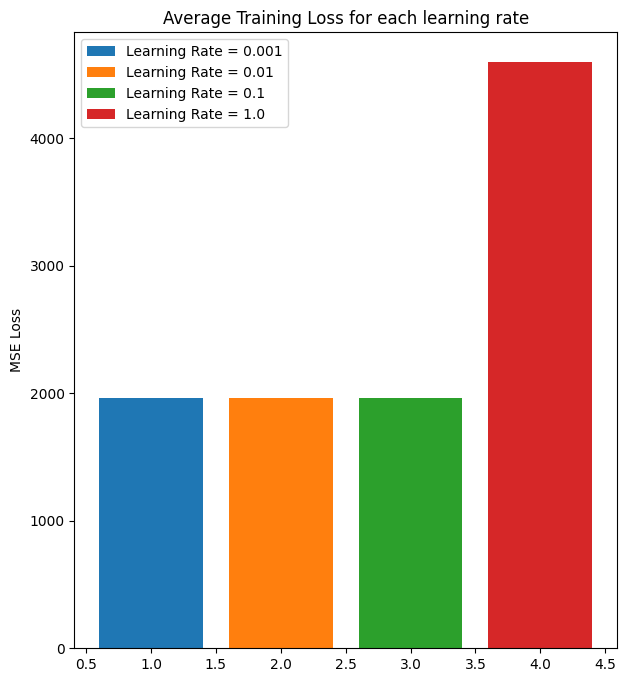

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 8))
width = 0.2
x = [1,2,3,4]
y = [np.mean(lr1["losses"]),
     np.mean(lr2["losses"]),
     np.mean(lr3["losses"]),
     np.mean(lr4["losses"])]

labels = ["Learning Rate = 0.001",
          "Learning Rate = 0.01",
          "Learning Rate = 0.1",
          "Learning Rate = 1.0"]

for i in range(len(x)):
  plt.bar(x[i], y[i], label=labels[i])

plt.ylabel("MSE Loss")
plt.title(f"Average Training Loss for each learning rate")
plt.legend()
plt.show()


### 5)
 When testing learning rates of 0.001, 0.01, 0.1, and 1.0, where the Sigmoid activation was used at the hidden layer and the hidden layer had 10 neurons, I found that a high learning rate too high decreased performance. The average losses for learning rates of 0.001, 0.01, and 0.1 were around 2000, and the final losses for these models were around 820. And when the learning rate was 1.0, the avereage loss was more than double that of the other learning rates, as the average loss exceeded 4000 and the final loss was just below 500.

---

## 6. Testing different number of neurons

neurons: 1

In [ ]:
n1 = train(X_train, Y_train, X_test, Y_test, 1, 0.01, 1000, 'sigmoid')

Training with 1 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.8027
    Epoch 100, Train Loss: 5546.8582
    Epoch 200, Train Loss: 5165.9847
    Epoch 300, Train Loss: 4834.2855
    Epoch 400, Train Loss: 4549.4800
    Epoch 500, Train Loss: 4299.2554
    Epoch 600, Train Loss: 4075.2775
    Epoch 700, Train Loss: 3872.2369
    Epoch 800, Train Loss: 3686.6094
    Epoch 900, Train Loss: 3515.9077
    Epoch 999, Train Loss: 3359.7862


neurons: 2

In [ ]:
n2 = train(X_train, Y_train, X_test, Y_test, 2, 0.01, 1000, 'sigmoid')

Training with 2 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.8887
    Epoch 100, Train Loss: 5397.8765
    Epoch 200, Train Loss: 4744.7347
    Epoch 300, Train Loss: 4240.0834
    Epoch 400, Train Loss: 3844.8875
    Epoch 500, Train Loss: 3522.2090
    Epoch 600, Train Loss: 3250.8788
    Epoch 700, Train Loss: 3018.0023
    Epoch 800, Train Loss: 2815.0330
    Epoch 900, Train Loss: 2635.9387
    Epoch 999, Train Loss: 2477.8227


neurons: 5

In [ ]:
n3 = train(X_train, Y_train, X_test, Y_test, 5, 0.01, 1000, 'sigmoid')

Training with 5 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.8103
    Epoch 100, Train Loss: 5053.3032
    Epoch 200, Train Loss: 3927.0724
    Epoch 300, Train Loss: 3266.1055
    Epoch 400, Train Loss: 2829.6807
    Epoch 500, Train Loss: 2509.5213
    Epoch 600, Train Loss: 2259.2266
    Epoch 700, Train Loss: 2055.1807
    Epoch 800, Train Loss: 1883.4184
    Epoch 900, Train Loss: 1735.0464
    Epoch 999, Train Loss: 1605.6027


neurons: 7

In [ ]:
n4 = train(X_train, Y_train, X_test, Y_test, 7, 0.01, 1000, 'sigmoid')

Training with 7 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.4423
    Epoch 100, Train Loss: 4860.0766
    Epoch 200, Train Loss: 3585.8258
    Epoch 300, Train Loss: 2925.0687
    Epoch 400, Train Loss: 2509.4140
    Epoch 500, Train Loss: 2211.9030
    Epoch 600, Train Loss: 1983.1511
    Epoch 700, Train Loss: 1798.5974
    Epoch 800, Train Loss: 1644.1872
    Epoch 900, Train Loss: 1511.2672
    Epoch 999, Train Loss: 1395.0997


neurons: 10

In [ ]:
n5 = train(X_train, Y_train, X_test, Y_test, 10, 0.01, 1000, 'sigmoid')

Training with 10 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.7285
    Epoch 100, Train Loss: 4664.7682
    Epoch 200, Train Loss: 3262.0567
    Epoch 300, Train Loss: 2620.6546
    Epoch 400, Train Loss: 2232.6934
    Epoch 500, Train Loss: 1962.1213
    Epoch 600, Train Loss: 1757.6936
    Epoch 700, Train Loss: 1594.3840
    Epoch 800, Train Loss: 1458.2985
    Epoch 900, Train Loss: 1341.2861
    Epoch 999, Train Loss: 1239.1920


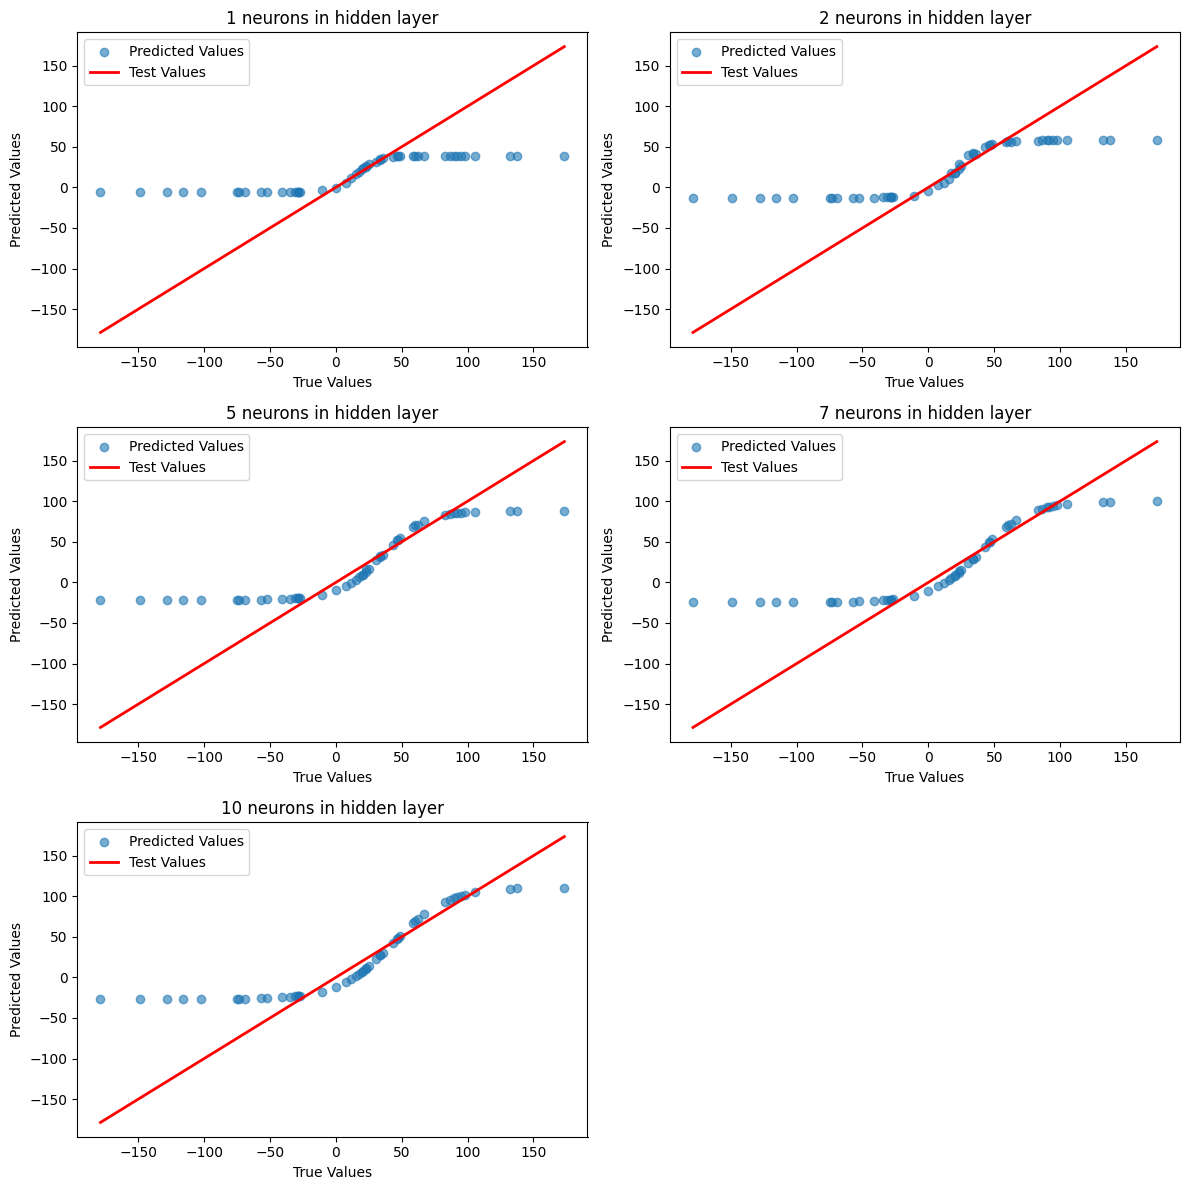

In [ ]:

results_list = [n1, n2, n3, n4, n5]
num_neurons = [1,2,5,7,10]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # 3 rows, 2 columns

# Flatten the 2D array of axes for easier iteration
axes = axes.flatten()

for i, (ax, results) in enumerate(zip(axes, results_list)):
    ax.scatter(Y_test, results["predictions"], alpha=0.6, label="Predicted Values")
    ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r', lw=2, label='Test Values')

    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{num_neurons[i]} neurons in hidden layer")
    ax.legend()

# Hide the last subplot (since there are 6 spaces but only 5 plots)
axes[-1].set_visible(False)
plt.title(f"True vs. Predicted for each model")
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


### 6a)
We **do not need to** change or derive the update rule again. Changing the number of neurons alters the structure of the given layer but does not change the process of backpropagation or updating weights. THe loss function and derivatives are the same since the only change is in the number of parameters and not the overall calculation.
### 6b)
Predictions are the worst when there is only one neuron. Increasing the number of neurons to 2 only has a slight improvement. When comparing the predictions of having 5 neurons and 7 neurons, we see some more improvement but the errors are quite noticeable. So even though increasing the number of neurons from 1-10 has a slight improvement in performance, the errors are still significant. The number of neurons alone won't improve the model performance. Instead we would need to modify the hyperparameters or use a different activation function instead of Sigmoid in the hidden layer.

---

## 7. Exploring different activation functions.

In [ ]:
# Storing results for multiple activation functions with same configuration.
relu_results = train(X_train, Y_train, X_test, Y_test, 10, 0.001, 1000, "relu")
sigmoid_results = train(X_train, Y_train, X_test, Y_test, 10, 0.001, 1000, "sigmoid")
tanh_results = train(X_train, Y_train, X_test, Y_test, 10, 0.001, 1000, "tanh")

Training with 10 hidden neurons using relu activation
    Epoch 0, Train Loss: 5716.7953
    Epoch 100, Train Loss: 98.8142
    Epoch 200, Train Loss: 81.9396
    Epoch 300, Train Loss: 52.7695
    Epoch 400, Train Loss: 20.6866
    Epoch 500, Train Loss: 2.9191
    Epoch 600, Train Loss: 0.3540
    Epoch 700, Train Loss: 0.0418
    Epoch 800, Train Loss: 0.0051
    Epoch 900, Train Loss: 0.0007
    Epoch 999, Train Loss: 0.0001
Training with 10 hidden neurons using sigmoid activation
    Epoch 0, Train Loss: 5716.7149
    Epoch 100, Train Loss: 4663.2509
    Epoch 200, Train Loss: 3261.3579
    Epoch 300, Train Loss: 2620.2556
    Epoch 400, Train Loss: 2232.4219
    Epoch 500, Train Loss: 1961.9193
    Epoch 600, Train Loss: 1757.5343
    Epoch 700, Train Loss: 1594.2529
    Epoch 800, Train Loss: 1458.1877
    Epoch 900, Train Loss: 1341.1942
    Epoch 999, Train Loss: 1239.1478
Training with 10 hidden neurons using tanh activation
    Epoch 0, Train Loss: 5716.7717
    Epoch 100, T

Comparing the loss curves for all three activation functions.

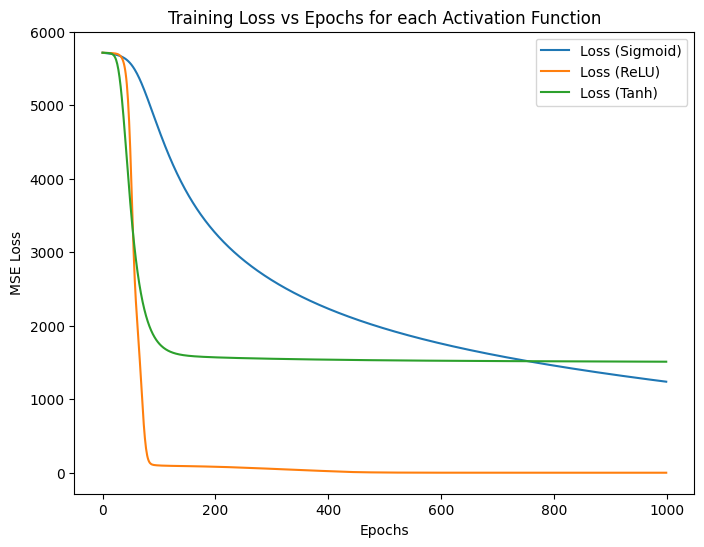

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(sigmoid_results["losses"], label="Loss (Sigmoid)")
plt.plot(relu_results["losses"], label="Loss (ReLU)")
plt.plot(tanh_results["losses"], label="Loss (Tanh)")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title(f"Training Loss vs Epochs for each Activation Function")
plt.legend()
plt.show()

Plotting the true and predicted labels for each activation function.

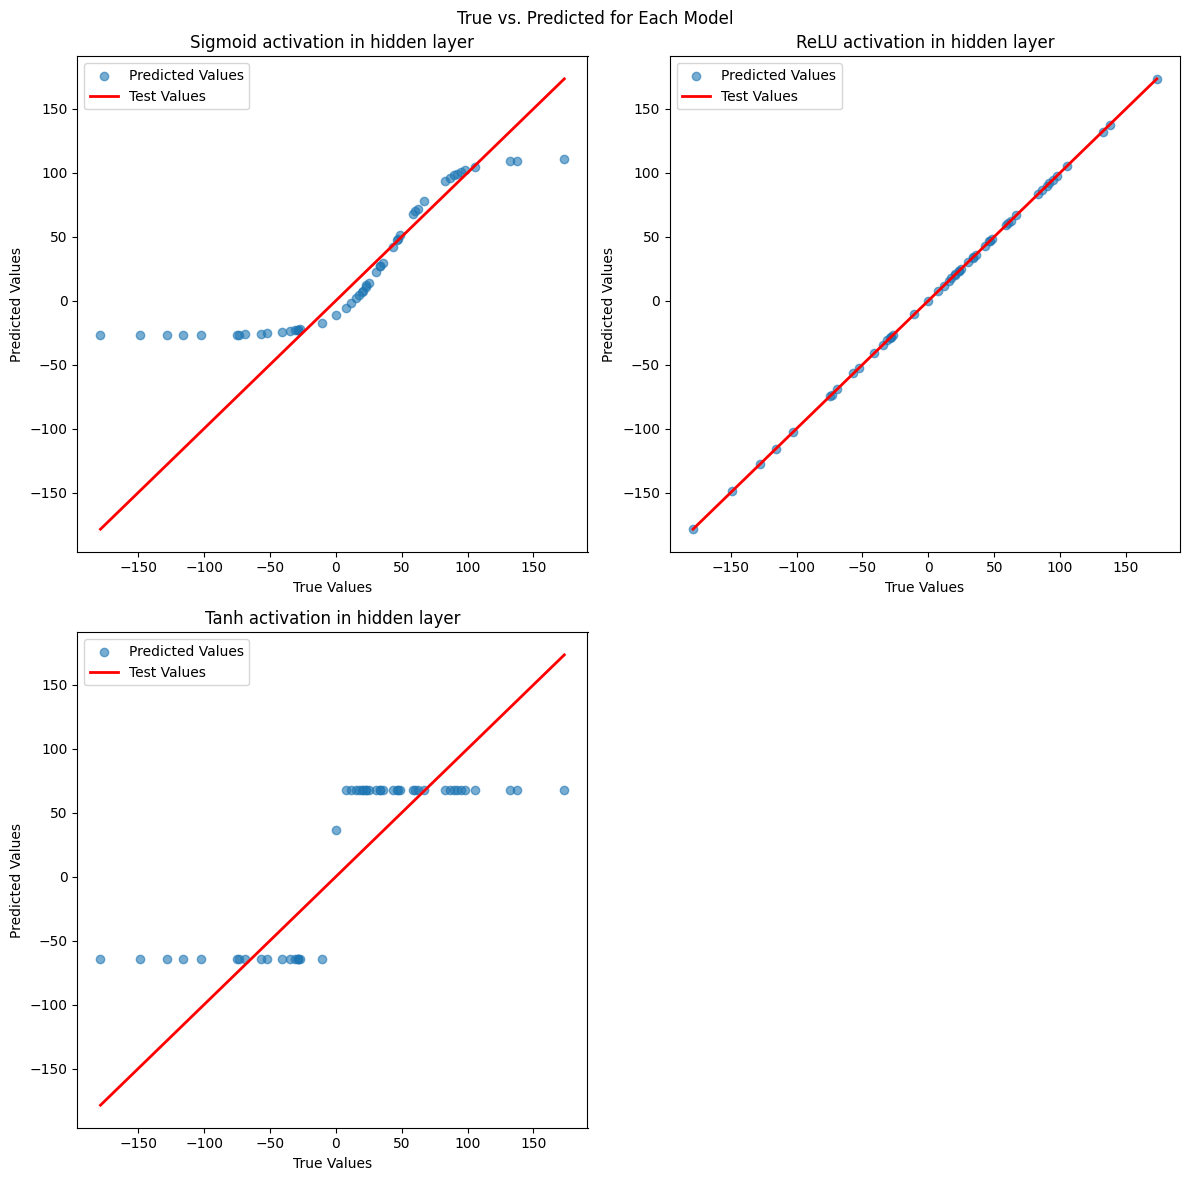

In [ ]:

results_list = [sigmoid_results, relu_results, tanh_results]
functions_list = ['Sigmoid', 'ReLU', 'Tanh']

fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # 2 rows, 2 columns

# Flatten the 2D array of axes
axes = axes.flatten()

for i, (ax, results) in enumerate(zip(axes[:3], results_list)):  # Use only first 3 subplots
    ax.scatter(Y_test, results["predictions"], alpha=0.6, label="Predicted Values")
    ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r', lw=2, label='Test Values')

    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.set_title(f"{functions_list[i]} activation in hidden layer")
    ax.legend()

# Hide the last (unused) subplot
axes[3].set_visible(False)

plt.suptitle("True vs. Predicted for Each Model")  # Set overall title
plt.tight_layout()  # Adjust layout for better spacing
plt.show()


In [ ]:
print(f'Sigmoid final loss: {sigmoid_results["final_loss"]}')
print(f'ReLU final loss: {relu_results["final_loss"]}')
print(f'Tanh final loss: {tanh_results["final_loss"]}')

Sigmoid final loss: 1239.147833660387
ReLU final loss: 9.070643022242048e-05
Tanh final loss: 1511.1550839377614


### 7a)
The plots show that using ReLU activation caused the best fit between the predictions and the test labels. So changing the update rule isn't necessary. Sigmoid and Tanh activations led to a poorer performance and changing the activation to ReLU fixed it. Since we have the choice between different activation functions, changing the update rule is **not necessary**.

When testing different activation functions and we notice exploding or vanishing gradients, if the training loss doesn't decrease or the convergence is unstable (oscillates or diverges), then we would need to alter the update rule.

### 7b)
When testing different learning rates, I noticed exploding gradients for higher learning rates (0.1, 1.0), and as a result, I couldn't properly plot the results due to a runtime error from the algorithm being unable to calculate values that high. I was able to solve this by applying gradient clipping during backpropagation. I only applied this when the learning rate was at or above 0.1, otherwise it would decrease model performance. For instance, when the number of neurons was 10, learning rate was 0.001, and ReLU activation was used, gradient clipping led to outliers in my predictions, and this caused the predictions to not fit the test labels as well. The models performed better for smaller learning rates without gradient clipping, but for larger learning rates, the model was more stable after gradient clipping.
### 7c)
It's clear that ReLU activation reduced loss the most, as the final loss reached a very small value around 0 after 1000 iterations while Sigmoid and Tanh activation functions had losses exceeding 1200.

Even though the ReLU activation function in the hidden layer allowed the loss to reach 0, this does not necessarily mean the model was the best. In fact, overfitting is likely in this scenario. In the graph for ReLU, it appears that the test data and the predicted labels fit almost perfectly.

---

For questions 8 and 9, I implemented separate train functions for early stopping and regularization. I originally planned to modify my original train function to account for these techniques, using booleans to make sure they were only used for the required questions. However, this ended up overcomplicating the original code, so I ultimately decided to write two new functions that are largely based on my original train function, but done separately to account for early stopping and regularization without unnecessarily complicating the previous code.

## 8) Early Stopping

In [ ]:
# Train the neural network with early stopping.
def early_stop(X_train, Y_train, X_test, Y_test, hidden_size, learning_rate, num_epochs, activation, patience):

    # Split the data into training and validation.
    split_index = int(0.8 * len(X_train))
    X_split, X_val = X_train[:split_index], X_train[split_index:]
    Y_split, Y_val = Y_train[:split_index], Y_train[split_index:]

    activation_func, activation_deriv = activation_functions[activation]
    print(f"Training, using Early Stopping")

    # Initialize the parameters.
    W1, b1, W2, b2 = initialize_params(X_split, hidden_size)

    losses_train = []
    losses_val = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):

        # Forward pass.
        Z1, A1, Z2 = forward_pass(X_split, W1, b1, W2, b2, activation_func)

        Z1_val, A1_val, Z2_val = forward_pass(X_val, W1, b1, W2, b2, activation_func)

        # Calculate the training loss.
        loss_train = mse_loss(Y_split, Z2)
        losses_train.append(loss_train)

        # Calculate the validation loss.
        loss_val = mse_loss(Y_val, Z2_val)
        losses_val.append(loss_val)

        # Early stopping based on loss improvement and specified patience.
        if loss_val < best_val_loss:
            best_val_loss = loss_val
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter > patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Backward propagation.
        dL_dW1, dL_db1, dL_dW2, dL_db2 = backpropagation(
            X_split, Y_split,
            Z1, A1, Z2, W2,
            activation_deriv, learning_rate
        )

        # Update the parameters.
        W1, b1, W2, b2 = update_params(
            W1, b1, W2, b2,
            dL_dW1, dL_db1, dL_dW2, dL_db2
        )

        # Print the loss at every 100 epochs and the final epoch.
        if epoch % 100 == 0 or epoch == num_epochs-1:
            print(f"    Epoch {epoch}, Train Loss: {loss_train:.4f}, Val Loss: {loss_val:.4f}")

    # Generate predictions.
    _, _, Y_pred = forward_pass(X_test, W1, b1, W2, b2, activation_func)

    # Return the parameters and predictions for further analysis.
    return {
        "hidden_size": hidden_size,
        "activation_function": activation,
        "final_loss": loss_train,
        "losses_train": losses_train,
        "losses_val": losses_val,
        "weights": (W1, b1, W2, b2),
        "predictions": Y_pred
    }

Testing for patience = 25, 50, 75, 100


In [ ]:
es1 = early_stop(X_train, Y_train, X_test, Y_test, hidden_size=10, learning_rate=0.001, num_epochs=1000, activation="sigmoid", patience=25)

es2 = early_stop(X_train, Y_train, X_test, Y_test, hidden_size=10, learning_rate=0.001, num_epochs=1000, activation="sigmoid", patience=50)

es3 = early_stop(X_train, Y_train, X_test, Y_test, hidden_size=10, learning_rate=0.001, num_epochs=1000, activation="sigmoid", patience=75)

es4 = early_stop(X_train, Y_train, X_test, Y_test, hidden_size=10, learning_rate=0.001, num_epochs=1000, activation="sigmoid", patience=100)

Training, using Early Stopping
    Epoch 0, Train Loss: 6313.8130, Val Loss: 3327.3098
Early stopping at epoch 26
Training, using Early Stopping
    Epoch 0, Train Loss: 6313.9078, Val Loss: 3327.2231
Early stopping at epoch 51
Training, using Early Stopping
    Epoch 0, Train Loss: 6314.6596, Val Loss: 3326.3331
    Epoch 100, Train Loss: 4477.8476, Val Loss: 3076.9127
    Epoch 200, Train Loss: 3078.2914, Val Loss: 2724.4941
    Epoch 300, Train Loss: 2478.8175, Val Loss: 2449.9272
    Epoch 400, Train Loss: 2118.0941, Val Loss: 2234.9774
    Epoch 500, Train Loss: 1867.7870, Val Loss: 2061.4945
    Epoch 600, Train Loss: 1678.9477, Val Loss: 1912.1540
    Epoch 700, Train Loss: 1527.8801, Val Loss: 1778.8788
    Epoch 800, Train Loss: 1401.8165, Val Loss: 1657.0812
    Epoch 900, Train Loss: 1293.4198, Val Loss: 1543.9861
    Epoch 999, Train Loss: 1199.0000, Val Loss: 1438.7686
Training, using Early Stopping
    Epoch 0, Train Loss: 6314.2824, Val Loss: 3326.7537
    Epoch 100, Tra

Compare the results for different patience values

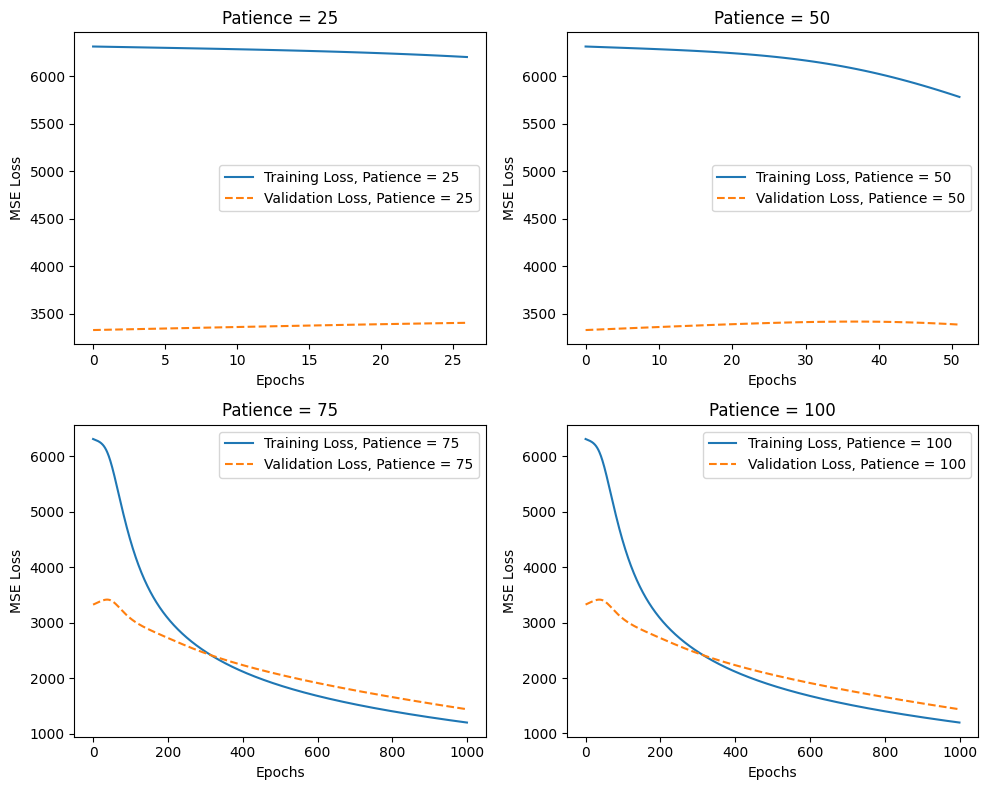

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# List of patience values and corresponding datasets
patience_values = [25, 50, 75, 100]
datasets = [es1, es2, es3, es4]

# Loop through the patience values and plot them in separate subplots
for i, (ax, es, patience) in enumerate(zip(axes.flat, datasets, patience_values)):
    ax.plot(es["losses_train"], label=f"Training Loss, Patience = {patience}")
    ax.plot(es["losses_val"], label=f"Validation Loss, Patience = {patience}", linestyle="dashed")

    ax.set_xlabel("Epochs")
    ax.set_ylabel("MSE Loss")
    ax.set_title(f"Patience = {patience}")
    ax.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### 8a)
For lower patience (<= 50), the training and validation losses do not change much, but there is a slight decrease in training loss for patience of 50. Compared to patience = 25, where the training and validation loss change very minimally, we see a slight increase and decrease for validation loss and a decrease in training loss near the end when patience is 50.

For the higher patience values of 75 and 100, thhe losses both decrease significantly. And at around 300 epochs, the training loss is actually lower than the validation loss. The model fits the data better for these higher patience values.

### 8b)
When patience <= 50, this indicates **underfitting**. Since training and validation loss do not improve much at all. At patience = 50, there is a decrease in training loss at the end, meaning that the model could improve if trained for more epochs.

For patience >= 75, the model performs much better as the losses decrease significantly. However, the difference between patience = 75 and patience = 100 is very minimal. So using a patience higher than 75 is redundant since the model does not significantly improve. After reaching this point, if we keep increasing the patience after the 100, there is the **potential for overfitting**.

Overfitting would occur if validation loss stops decreasing and starts to increase while training loss decreases. This would mean that the model memorizes the data instead of learning from it. However, this model has not reached that point yet.

---

## 9) Applying another regularization technique.
I chose L2 Regularization.

In [ ]:
# Function to apply L2 regularization
def l2_reg(X_train, Y_train, X_test, Y_test, hidden_size, learning_rate, num_epochs, activation, lambda_reg=0.01):

    # Split the data into training and validation.
    split_index = int(0.8 * len(X_train))
    X_split, X_val = X_train[:split_index], X_train[split_index:]
    Y_split, Y_val = Y_train[:split_index], Y_train[split_index:]

    activation_func, activation_deriv = activation_functions[activation]
    print(f"Training, using L2 regularization")

    # Initialize the parameters.
    W1, b1, W2, b2 = initialize_params(X_split, hidden_size)

    losses_train = []
    losses_val = []

    for epoch in range(num_epochs):

        # Forward pass.
        Z1, A1, Z2 = forward_pass(X_split, W1, b1, W2, b2, activation_func)
        Z1_val, A1_val, Z2_val = forward_pass(X_val, W1, b1, W2, b2, activation_func)

        # Calculate training loss.
        loss_train = mse_loss(Y_split, Z2) + (lambda_reg / 2) * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
        losses_train.append(loss_train)

        # Calculate validation loss.
        loss_val = mse_loss(Y_val, Z2_val) + (lambda_reg / 2) * (np.sum(W1 ** 2) + np.sum(W2 ** 2))
        losses_val.append(loss_val)

        # Backward propagation.
        dL_dW1, dL_db1, dL_dW2, dL_db2 = backpropagation(
            X_split, Y_split,
            Z1, A1, Z2, W2,
            activation_deriv, learning_rate
        )

        # Applying the regularization parameter (lambda) to update the parameters.
        W1 -= learning_rate * (dL_dW1 + lambda_reg * W1)
        b1 -= learning_rate * dL_db1
        W2 -= learning_rate * (dL_dW2 + lambda_reg * W2)
        b2 -= learning_rate * dL_db2

        if epoch % 100 == 0 or epoch == num_epochs-1:
            print(f"    Epoch {epoch}, Train Loss: {loss_train:.4f}, Val Loss: {loss_val:.4f}")

    _, _, Y_pred = forward_pass(X_test, W1, b1, W2, b2, activation_func)

    return {
        "hidden_size": hidden_size,
        "activation_function": activation,
        "final_loss": loss_train,
        "losses_train": losses_train,
        "losses_val": losses_val,
        "weights": (W1, b1, W2, b2),
        "predictions": Y_pred
    }

L2 Regularization with smaller lambda, 0.01

Training, using L2 regularization
    Epoch 0, Train Loss: 6314.1369, Val Loss: 3326.9426
    Epoch 100, Train Loss: 4460.3143, Val Loss: 3072.2310
    Epoch 200, Train Loss: 3075.0295, Val Loss: 2724.0041
    Epoch 300, Train Loss: 2480.7165, Val Loss: 2451.9037
    Epoch 400, Train Loss: 2123.0100, Val Loss: 2239.0155
    Epoch 500, Train Loss: 1874.7901, Val Loss: 2067.0551
    Epoch 600, Train Loss: 1687.4983, Val Loss: 1918.9186
    Epoch 700, Train Loss: 1537.6524, Val Loss: 1786.6558
    Epoch 800, Train Loss: 1412.6136, Val Loss: 1665.7605
    Epoch 900, Train Loss: 1305.0988, Val Loss: 1553.4664
    Epoch 999, Train Loss: 1211.3198, Val Loss: 1448.6948


<ipython-input-32-5f9502cca32c>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


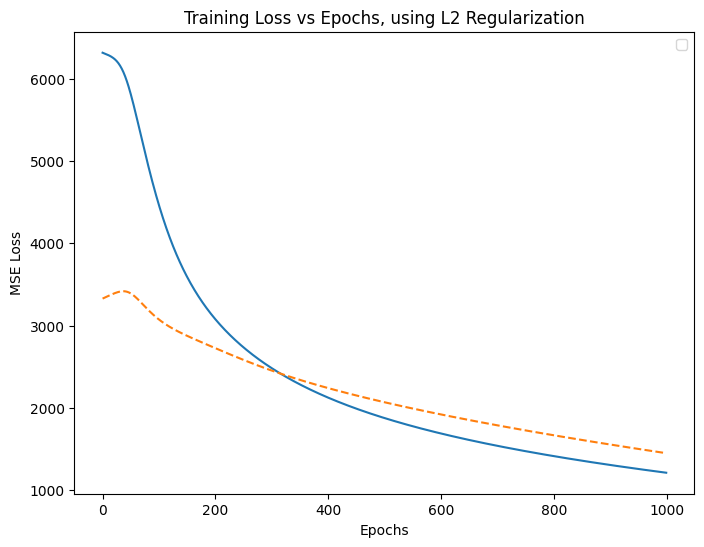

In [ ]:
l2_results1 = l2_reg(X_train, Y_train, X_test, Y_test, hidden_size=10, learning_rate=0.001, num_epochs=1000, activation="sigmoid", lambda_reg=0.01)
plt.figure(figsize=(8, 6))
plt.plot(l2_results1["losses_train"])
plt.plot(l2_results1["losses_val"], linestyle='--')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title(f"Training Loss vs Epochs, using L2 Regularization")
plt.legend()
plt.show()

L2 regularization with larger lambda, 1.0

Training, using L2 regularization
    Epoch 0, Train Loss: 6314.2791, Val Loss: 3326.7893
    Epoch 100, Train Loss: 4616.5731, Val Loss: 3164.8889
    Epoch 200, Train Loss: 3455.5490, Val Loss: 2987.8675
    Epoch 300, Train Loss: 3029.9590, Val Loss: 2862.5692
    Epoch 400, Train Loss: 2800.6980, Val Loss: 2754.3943
    Epoch 500, Train Loss: 2648.8420, Val Loss: 2656.0329
    Epoch 600, Train Loss: 2535.5288, Val Loss: 2562.9390
    Epoch 700, Train Loss: 2445.2278, Val Loss: 2475.0841
    Epoch 800, Train Loss: 2370.7224, Val Loss: 2393.2276
    Epoch 900, Train Loss: 2308.1146, Val Loss: 2317.9072
    Epoch 999, Train Loss: 2255.4623, Val Loss: 2249.9477


<ipython-input-33-89e657b6b425>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


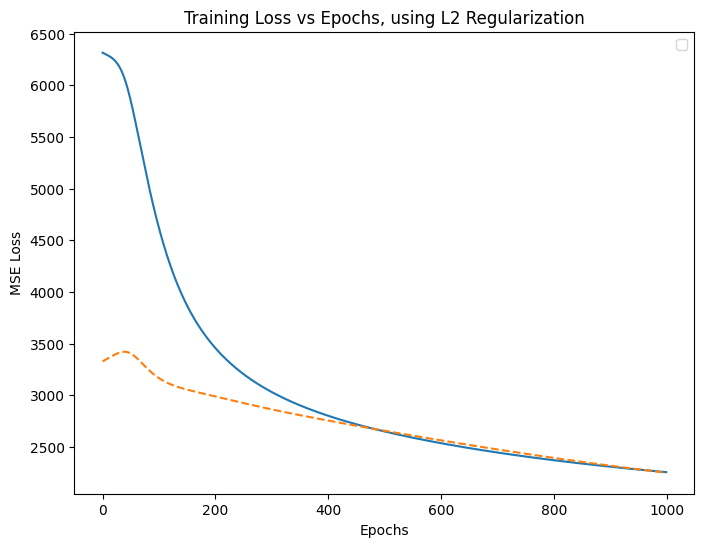

In [ ]:
l2_results2 = l2_reg(X_train, Y_train, X_test, Y_test, hidden_size=10, learning_rate=0.001, num_epochs=1000, activation="sigmoid", lambda_reg=1.0)
plt.figure(figsize=(8, 6))
plt.plot(l2_results2["losses_train"])
plt.plot(l2_results2["losses_val"], linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title(f"Training Loss vs Epochs, using L2 Regularization")
plt.legend()
plt.show()

L2 Regularization with a much higher lambda, 10

Training, using L2 regularization
    Epoch 0, Train Loss: 6314.5108, Val Loss: 3326.5398
    Epoch 100, Train Loss: 5479.4598, Val Loss: 3607.9814
    Epoch 200, Train Loss: 5209.5117, Val Loss: 3887.9728
    Epoch 300, Train Loss: 5181.1204, Val Loss: 3960.3145
    Epoch 400, Train Loss: 5171.3390, Val Loss: 3956.0882
    Epoch 500, Train Loss: 5164.4837, Val Loss: 3934.5004
    Epoch 600, Train Loss: 5159.1759, Val Loss: 3911.3733
    Epoch 700, Train Loss: 5155.0291, Val Loss: 3890.3032
    Epoch 800, Train Loss: 5151.7850, Val Loss: 3871.8140
    Epoch 900, Train Loss: 5149.2455, Val Loss: 3855.7257
    Epoch 999, Train Loss: 5147.2741, Val Loss: 3841.8669


<ipython-input-34-5f464a10e67f>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


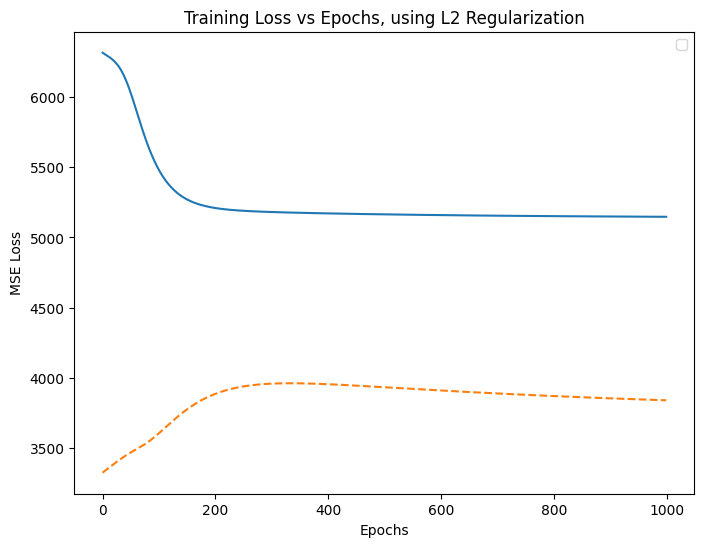

In [ ]:
l2_results3 = l2_reg(X_train, Y_train, X_test, Y_test, hidden_size=10, learning_rate=0.001, num_epochs=1000, activation="sigmoid", lambda_reg=10.0)
plt.figure(figsize=(8, 6))
plt.plot(l2_results3["losses_train"])
plt.plot(l2_results3["losses_val"], linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title(f"Training Loss vs Epochs, using L2 Regularization")
plt.legend()
plt.show()

### 9)
I chose to apply L2 regularization for the neural network.

L2, or Ridge Regression, works by adding a penalty term (lambda * sum of the squared weights) to the loss functions and prevents weights from being too large. The penalty is determined by the lambda value.

Early stopping, however, does not alter the loss function. Instead, this technique monitors the loss values over epochs and stops the training if overfitting is detected (when the loss stops decreasing and starts increasing). Early stopping does not directly effect the actual weights. This technique relies on a hyperparameter, patience, to determine the amount of epochs to wait before stopping.

Early Stopping and L2 regularization can both prevent overfitting (either by controlling complexity or preventing excessive training), both require hyperparameters, and also stabilize training.

When comparing the plots of both techniques, I found that **early stopping** was a better regularization technique. When using L2 regularization, I had to use smaller lambdas, a value like 0.01, to have similar losses as early stopping. When I used a lambda of 1.0, I had even higher losses. Lambdas smaller than 0.01 had minimal effect on performance, while values higher than 1.0 resulted in higher losses. And when using an even higher lambda, 10, the validation loss actually increased after 200 epochs and then slowly decreased while training loss decreased after 200 epochs.

In short, I prefer **Early Stopping** for this dataset.